# Speaker Identification using Classical Machine Learning

In this notebook, we classify speakers using audio samples. We extract MFCC features and use classical ML models such as:
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Logistic Regression (LR)
- Random Forest (RF)
- Ensemble models: Voting & Stacking

Dataset: Mozilla Common Voice (subset)
Features: MFCC (13 coefficients)


## 1. Setup and Imports
We import the necessary libraries for audio processing, feature extraction, model training, and evaluation.

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

## 2. Load and Label Audio Data

We use the Mozilla Common Voice dataset. All audio `.wav` files are located in the `clips/` directory. Each audio clip is linked to a speaker via the `client_id` field in `validated.tsv`.

Steps:
- Load metadata (`validated.tsv`)
- Select a subset of speakers (e.g., top 10 with the most recordings)
- Extract MFCCs from each clip and label using `client_id`


data/
└── cv-corpus-21.0-delta-2025-03-14-en
    └── cv-corpus-21.0-delta-2025-03-14
        └── en
            ├── clip_durations.tsv
            ├── clips                                                        <-- all audio .mp3 files here
            │   └── common_voice_en_41980499.mp3                             <-- metadata including speaker_id                    
            ├── invalidated.tsv
            ├── other.tsv
            ├── reported.tsv
            ├── unvalidated_sentences.tsv
            ├── validated_sentences.tsv
            └── validated.tsv

In [4]:

# --- New dataset path ---
base_dir = "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en"
clips_dir = os.path.join(base_dir, "clips")
metadata_file = os.path.join(base_dir, "validated.tsv")

# --- Load metadata ---
df = pd.read_csv(metadata_file, sep="\t")
df = df[['path', 'client_id']]  # Keep only necessary columns

# --- Filter all speakers with at least MIN_CLIPS ---
MIN_CLIPS_PER_SPEAKER = 10

speaker_counts = df['client_id'].value_counts()
eligible_speakers = speaker_counts[speaker_counts >= MIN_CLIPS_PER_SPEAKER].index

df = df[df['client_id'].isin(eligible_speakers)]
df = df.groupby('client_id').head(MIN_CLIPS_PER_SPEAKER)

print(f"Selected {df['client_id'].nunique()} speakers")
print(f"Total clips: {len(df)}")

# --- Feature extraction ---
def extract_features(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    delta = np.mean(librosa.feature.delta(mfcc), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    return np.concatenate([mfcc_mean, delta, chroma, contrast])

# --- Process all samples ---
X, y = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(clips_dir, row['path'])
    try:
        features = extract_features(file_path)
        X.append(features)
        y.append(row['client_id'])
    except Exception as e:
        print(f"Error with {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"\nFeature matrix: {X.shape}")
print(f"Labels: {y.shape}")

# --- Save to .npz ---
output_dir = "../audios/"
save_path = os.path.join(output_dir, "processed_dataset.npz")
np.savez_compressed(save_path, X=X, y=y)
print("Saved dataset to processed_data.npz")


Selected 41 speakers
Total clips: 410


100%|██████████| 410/410 [01:12<00:00,  5.64it/s]


Feature matrix: (410, 45)
Labels: (410,)
Saved dataset to processed_data.npz


In [32]:
# --- Describe extracted features ---
print("\n📊 Extracted Features Summary:")
print("- MFCCs (mean):             13 coefficients")
print("- Delta MFCCs (mean):       13 coefficients")
print("- Chroma STFT (mean):       12 coefficients")
print("- Spectral Contrast (mean): 7 coefficients")
print(f"Total features per sample: {X.shape[1]} features")



📊 Extracted Features Summary:
- MFCCs (mean):             13 coefficients
- Delta MFCCs (mean):       13 coefficients
- Chroma STFT (mean):       12 coefficients
- Spectral Contrast (mean): 7 coefficients
Total features per sample: 45 features


In [18]:
import numpy as np

data = np.load("../audios/processed_dataset.npz")
X = data['X']
y = data['y']


In [19]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of unique speakers:", len(np.unique(y)))
print("Feature dimension per sample:", X.shape[1] if len(X.shape) > 1 else "Invalid")


X shape: (410, 45)
y shape: (410,)
Number of unique speakers: 41
Feature dimension per sample: 45


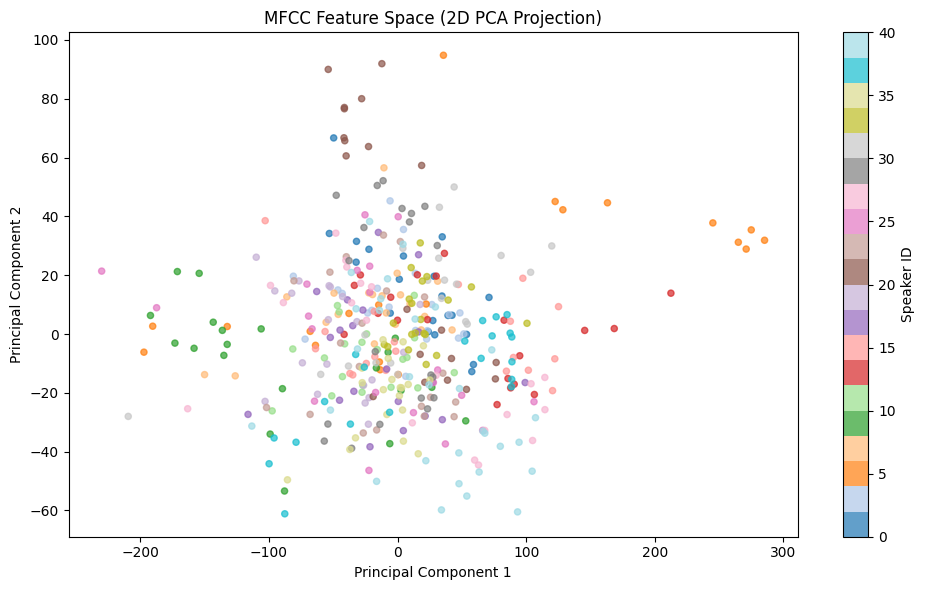

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce MFCC features to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot with colors by speaker
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pd.factorize(y)[0], cmap='tab20', s=20, alpha=0.7)

plt.title("MFCC Feature Space (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Speaker ID")
plt.tight_layout()
plt.show()


In [25]:
# Load the TSV metadata
tsv_path = "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv"
df = pd.read_csv(tsv_path, sep='\t')

In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Load metadata
df_full = pd.read_csv(tsv_path, sep='\t')
df_full = df_full[['client_id', 'gender', 'age']].dropna()

# 2. Build feature DataFrame
df_features = pd.DataFrame(X, columns=[f'mfcc_{i}' for i in range(X.shape[1])])
df_features['client_id'] = y

# 3. Merge on client_id
df_plot = pd.merge(df_features, df_full, on='client_id', how='inner')

# 4. Drop rows with missing gender or age (optional: keep only usable samples)
df_plot_filtered = df_plot.dropna(subset=['gender', 'age']).copy()

# 5. Apply PCA on the MFCCs
mfcc_cols = [f'mfcc_{i}' for i in range(13)]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_plot_filtered[mfcc_cols].values)

df_plot_filtered['PC1'] = X_pca[:, 0]
df_plot_filtered['PC2'] = X_pca[:, 1]


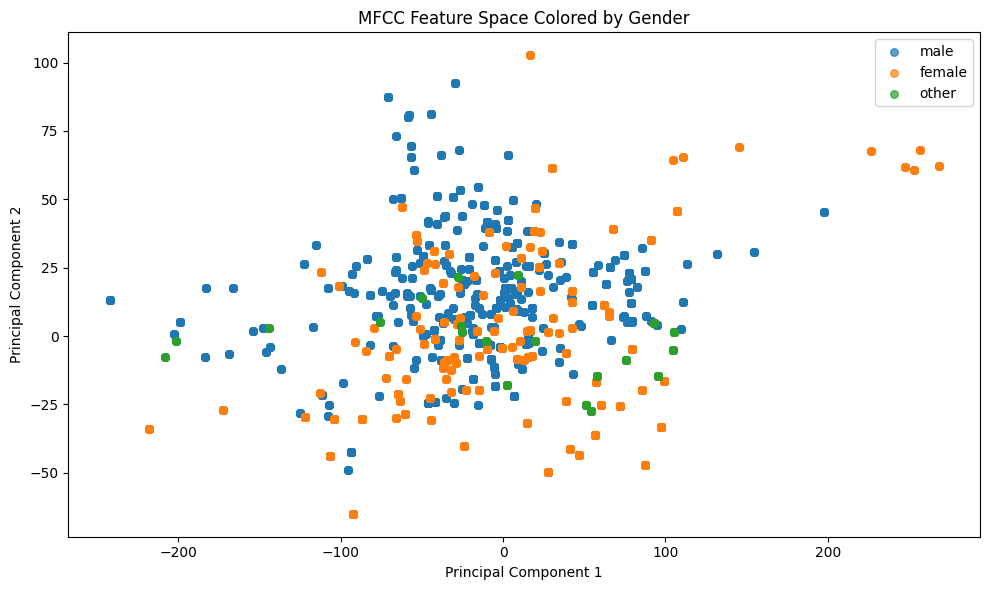

In [27]:
plt.figure(figsize=(10, 6))
for gender in df_plot_filtered['gender'].unique():
    subset = df_plot_filtered[df_plot_filtered['gender'] == gender]
    plt.scatter(subset['PC1'], subset['PC2'], label=gender, alpha=0.7, s=30)

plt.title("MFCC Feature Space Colored by Gender")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


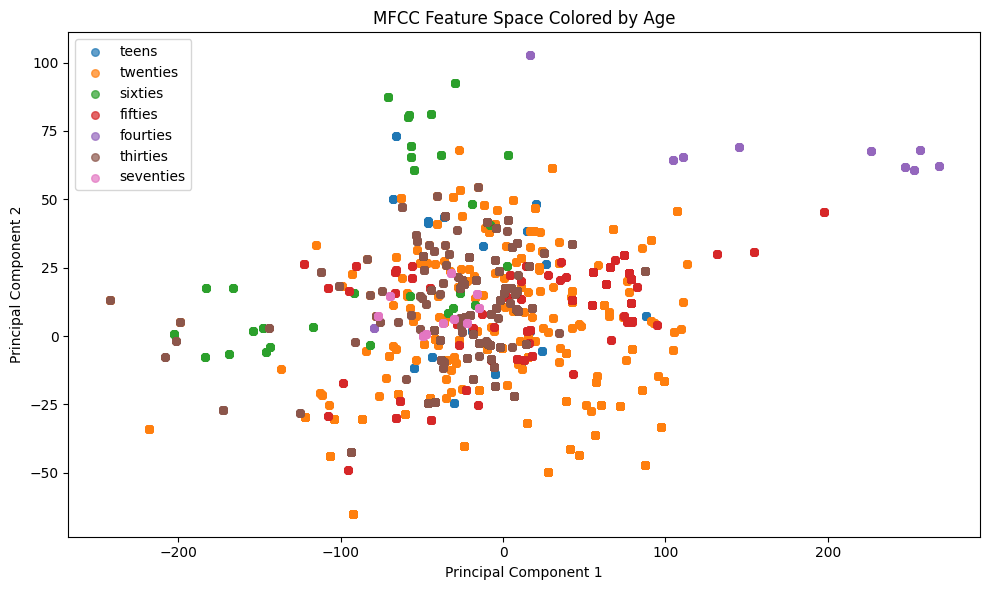

In [28]:
plt.figure(figsize=(10, 6))
for age in df_plot_filtered['age'].unique():
    subset = df_plot_filtered[df_plot_filtered['age'] == age]
    plt.scatter(subset['PC1'], subset['PC2'], label=age, alpha=0.7, s=30)

plt.title("MFCC Feature Space Colored by Age")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


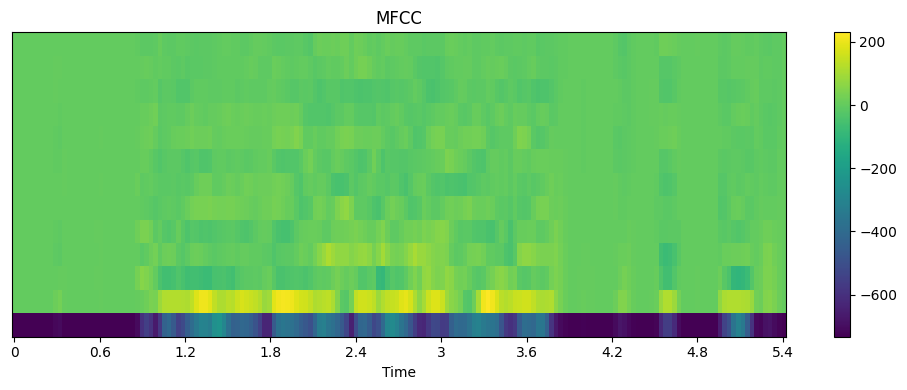

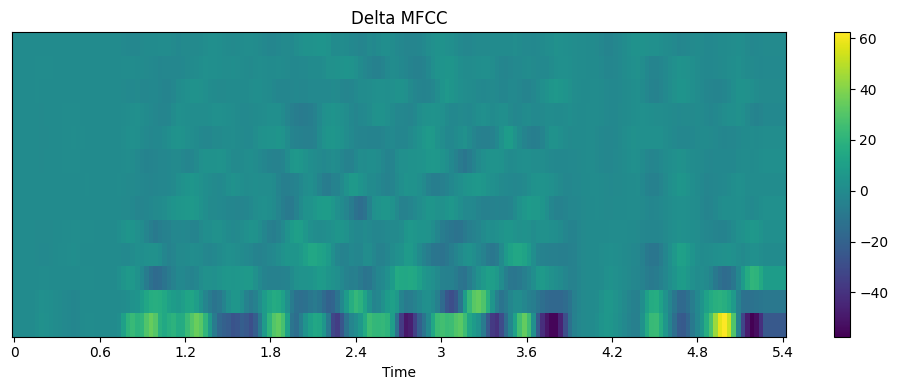

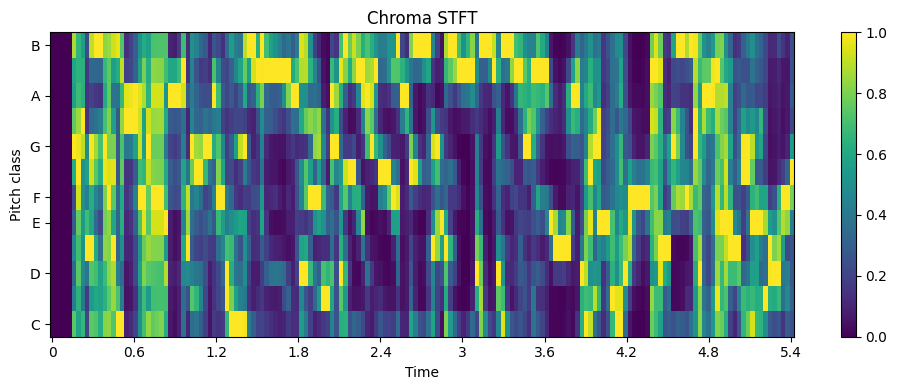

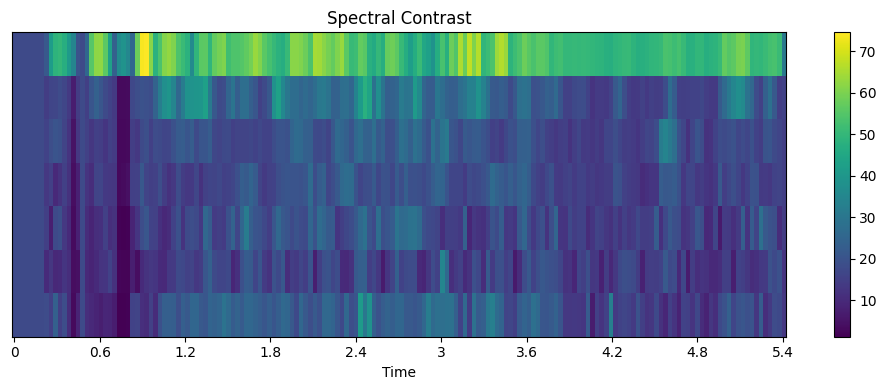

In [31]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# --- Load one audio file ---
audio_path =  "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en/clips/common_voice_en_38487408.mp3" # adjust if needed
y, sr = librosa.load(audio_path, sr=16000)

# --- Extract full features ---
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
delta = librosa.feature.delta(mfcc)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# --- Set output folder ---
output_folder = "visualizations"
os.makedirs(output_folder, exist_ok=True)

# --- Save MFCC ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "mfcc_visualization.png"))
plt.show()

# --- Save Delta MFCC ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(delta, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("Delta MFCC")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "delta_mfcc_visualization.png"))
plt.show()

# --- Save Chroma STFT ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("Chroma STFT")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "chroma_visualization.png"))
plt.show()

# --- Save Spectral Contrast ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(contrast, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("Spectral Contrast")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "spectral_contrast_visualization.png"))
plt.show()


# Mel Spectrogram extraction

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

input_dir = "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en/clips"
output_dir = "../pictures/spectrograms"
Path(output_dir).mkdir(parents=True, exist_ok=True)

for filename in os.listdir(input_dir):
    if not filename.endswith(".mp3"):
        continue
    file_path = os.path.join(input_dir, filename)
    
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Save as grayscale PNG
        fig = plt.figure(figsize=(1.28, 1.28), dpi=100)
        plt.axis('off')
        librosa.display.specshow(mel_db, sr=sr, cmap='gray_r')
        out_path = os.path.join(output_dir, filename.replace(".mp3", ".png"))
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    except Exception as e:
        print(f"Failed to process {filename}: {e}")


## 3. Prepare the Dataset: Encode, Scale, and Split

Before training, we need to preprocess the dataset:

1. **Load the `.npz` file**:
   - This file contains `X` (feature vectors) and `y` (speaker labels).

2. **Encode speaker labels**:
   - Since machine learning models require numeric class labels, we convert speaker IDs (e.g., `c002dfbc...`) to integers (e.g., `0`, `1`, `2`, ...).

3. **Scale the features**:
   - Our features include MFCC, chroma, and spectral contrast, which have different value ranges.
   - We use `StandardScaler` to normalize the features so they all have the same scale (mean = 0, std = 1). This improves model performance, especially for distance-based algorithms like KNN and SVM.

4. **Split the dataset**:
   - We use an 80/20 train-test split with stratification to ensure each speaker is equally represented in both sets.


In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os

# --- Load the saved .npz file ---
data = np.load("../audios/processed_dataset.npz")
X = data['X']
y = data['y']

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

# --- Encode speaker labels to integers ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

# --- Create directory if needed ---
output_dir = "../audios/splits"
os.makedirs(output_dir, exist_ok=True)

# --- Save splits ---
np.savez_compressed(os.path.join(output_dir, "train.npz"), X=X_train, y=y_train)
np.savez_compressed(os.path.join(output_dir, "test.npz"), X=X_test, y=y_test)

print("Saved training set to train.npz")
print("Saved test set to test.npz")


Loaded X shape: (410, 45)
Loaded y shape: (410,)
Training set: (328, 45), Labels: (328,)
Test set: (82, 45), Labels: (82,)
Saved training set to train.npz
Saved test set to test.npz


## Visualizing Feature Space Before and After Scaling

We use PCA to project the high-dimensional feature vectors down to 2D, so we can visualize them.

- The left plot shows the features **before scaling**.
- The right plot shows the features **after scaling** with `StandardScaler`.

Scaling standardizes the feature ranges, making the dataset more balanced and improving model performance — especially for algorithms that rely on distance (like KNN and SVM).


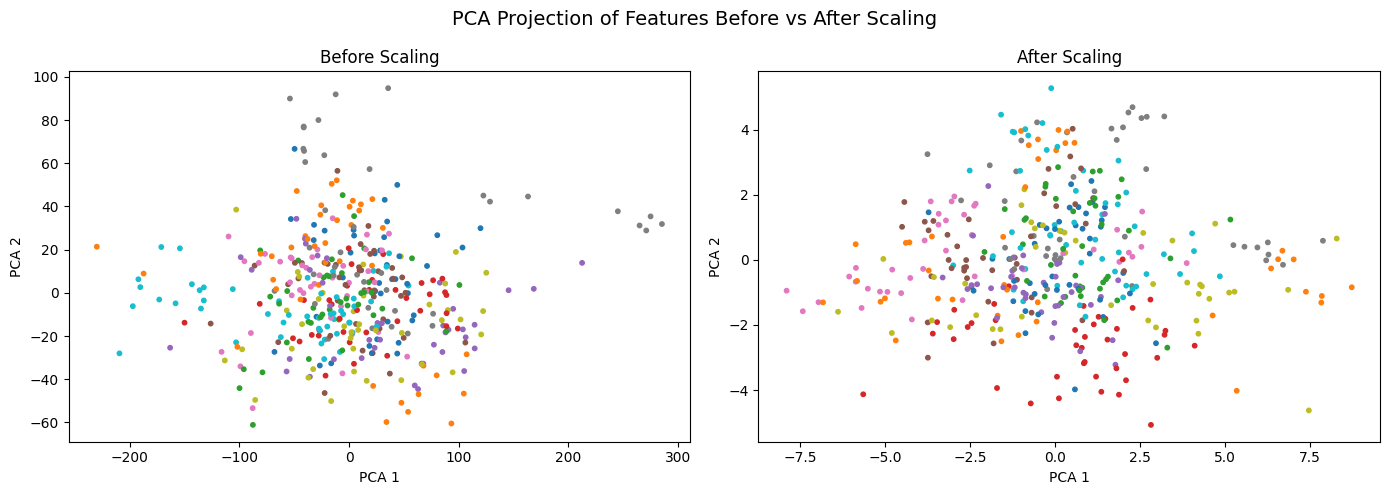

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensions for plotting
pca = PCA(n_components=2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Before scaling
X_pca_raw = pca.fit_transform(X)

# After scaling
X_pca_scaled = pca.fit_transform(X_scaled)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw features
axes[0].scatter(X_pca_raw[:, 0], X_pca_raw[:, 1], c=y_encoded, cmap='tab10', s=10)
axes[0].set_title("Before Scaling")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# Scaled features
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=y_encoded, cmap='tab10', s=10)
axes[1].set_title("After Scaling")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

plt.suptitle("PCA Projection of Features Before vs After Scaling", fontsize=14)
plt.tight_layout()
plt.show()


## 🔹 K-Nearest Neighbors (KNN)

KNN is a simple, non-parametric classification algorithm.

- It works by **finding the k closest samples** in the training data to a test sample, using a distance metric (usually Euclidean).
- It assigns the label by **majority vote** among those neighbors.

KNN is sensitive to feature scale (why we scaled earlier) and works well with balanced datasets.


In [2]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Initialize KNN with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on training data
knn.fit(X_train, y_train)

print("KNN model has been trained.")

# Save the trained KNN model
joblib.dump(knn, "../models/knn_model.joblib")
print("KNN model has been saved to models/knn_model.joblib.")


KNN model has been trained.
KNN model has been saved to models/knn_model.joblib.


## 🔹 Support Vector Machine (SVM)

SVM is a powerful classifier that tries to **maximize the margin** between classes.

- It finds a **hyperplane** that best separates the classes in high-dimensional space.
- Works well for both linear and non-linear data.
- Sensitive to scale and works great with a small number of samples per class.

We'll use a linear kernel to start with.


In [4]:
from sklearn.svm import SVC

# Initialize SVM with linear kernel
svm = SVC(kernel='linear', probability=True)

# Fit the model on training data
svm.fit(X_train, y_train)

print("SVM model has been trained.")

# Save the trained SVM model
joblib.dump(svm, "../models/svm_model.joblib")
print("SVM model has been saved to models/svm_model.joblib.")

SVM model has been trained.
SVM model has been saved to models/svm_model.joblib.


## 🔹 Logistic Regression

Logistic Regression is a linear model used for classification.

- It models the **probability** that a sample belongs to a class using the logistic (sigmoid) function.
- It's simple, efficient, and interpretable.
- Performs well when classes are linearly separable or almost so.


In [5]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression
lr = LogisticRegression(max_iter=1000)

# Fit the model on training data
lr.fit(X_train, y_train)

print("Logistic Regression model has been trained.")

# Save the trained logistic regression model
joblib.dump(lr, "../models/logistic_regression_model.joblib")
print("Logistic Regression model has been saved to models/logistic_regression_model.joblib.")


Logistic Regression model has been trained.
Logistic Regression model has been saved to models/logistic_regression_model.joblib.


## 🔹 Random Forest Classifier

Random Forest is an **ensemble method** made up of many decision trees.

- Each tree is trained on a random subset of the data and features.
- The final prediction is made by **majority voting** across all trees.
- It can handle non-linear relationships and is robust to noise.

It works well out of the box for many datasets.


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rf.fit(X_train, y_train)

print("Random Forest model has been trained.")

# Save the trained logistic regression model
joblib.dump(lr, "../models/random_forest_model.joblib")
print("Random Forest model has been saved to models/random_forest_model.joblib.")


Random Forest model has been trained.
Random Forest model has been saved to models/random_forest_model.joblib.


## Model Evaluation: Predictions and Performance

Now that all models have been trained, it is time to evaluate how well they perform on unseen test data.

For each model, we will:
1. Use `.predict(X_test)` to generate predicted labels.
2. Compare these predictions to the true labels (`y_test`).
3. Measure performance using the following metrics:
   - **Classification Accuracy**: The overall percentage of correct predictions.
   - **Classification Report**: Includes precision, recall, and F1-score per class.
   - **Confusion Matrix**: A visual breakdown showing which speakers were predicted correctly and which were confused.

---

## Evaluation Strategy (Project Specification)

To align with the evaluation methodology described in the project specification, we apply:

- **Classification Accuracy**  
  Quantifies the overall correctness of model predictions.

- **Confusion Matrix**  
  Helps us identify which speakers are being misclassified and how often.

- **5-Fold Cross-Validation**  
  Increases the reliability of model performance estimates by testing the model on multiple different subsets of the data.  
  This reduces the likelihood of misleading results from a single train-test split.


# KNN Evaluation

KNN Accuracy: 0.8415


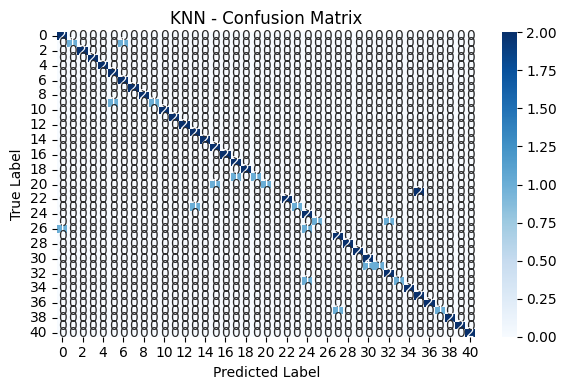

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       0.67      1.00      0.80         2
          16       1.00      1.00      1.00         2


/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_knn = knn.predict(X_test)

# Accuracy
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {acc_knn:.4f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-Fold Cross-Validation for KNN
scores_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

print("KNN 5-Fold Cross-Validation Accuracy Scores:", scores_knn)
print("Mean Accuracy:", np.mean(scores_knn))
print("Standard Deviation:", np.std(scores_knn))


KNN 5-Fold Cross-Validation Accuracy Scores: [0.90909091 0.83333333 0.8030303  0.84615385 0.83076923]
Mean Accuracy: 0.8444755244755244
Standard Deviation: 0.035235442338377866


# SVM Evaluation

SVM Accuracy: 0.9146


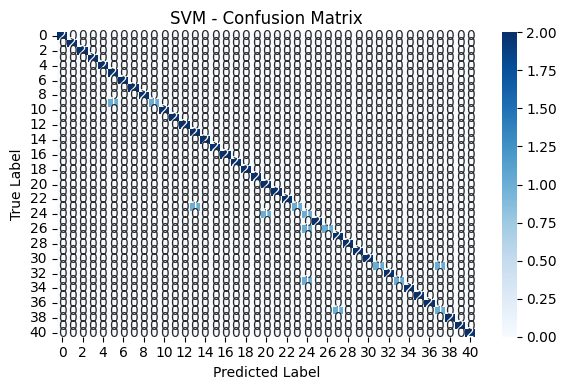

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_svm = svm.predict(X_test)

# Accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-Fold CV on training data
scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')

print("SVM 5-Fold Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Standard Deviation:", np.std(scores))


SVM 5-Fold Cross-Validation Accuracy Scores: [0.96969697 0.90909091 0.96969697 0.92307692 0.86153846]
Mean Accuracy: 0.9266200466200466
Standard Deviation: 0.040661233889883734


# Logistic Regression

Logistic Regression Accuracy: 0.9634


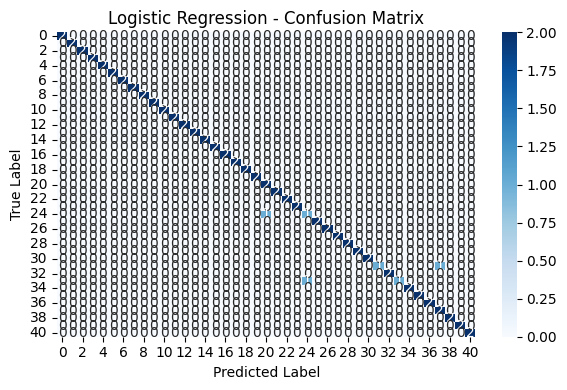

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00     

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_lr = lr.predict(X_test)

# Accuracy
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


In [16]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-Fold Cross-Validation for Logistic Regression
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')

print("Logistic Regression 5-Fold Cross-Validation Accuracy Scores:", scores_lr)
print("Mean Accuracy:", np.mean(scores_lr))
print("Standard Deviation:", np.std(scores_lr))


Logistic Regression 5-Fold Cross-Validation Accuracy Scores: [0.96969697 0.93939394 0.96969697 0.92307692 0.90769231]
Mean Accuracy: 0.9419114219114221
Standard Deviation: 0.024803617373275504


# Random Forest

Random Forest Accuracy: 0.9024


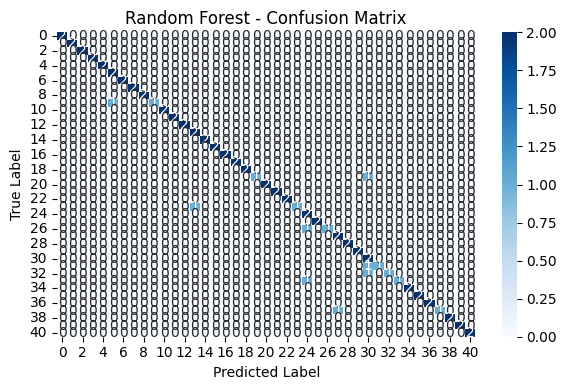

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00 

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


In [18]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-Fold Cross-Validation for Random Forest
scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Random Forest 5-Fold Cross-Validation Accuracy Scores:", scores_rf)
print("Mean Accuracy:", np.mean(scores_rf))
print("Standard Deviation:", np.std(scores_rf))


Random Forest 5-Fold Cross-Validation Accuracy Scores: [0.95454545 0.95454545 0.87878788 0.84615385 0.90769231]
Mean Accuracy: 0.9083449883449883
Standard Deviation: 0.04245174446056387


# CNN Deep Learning

In [3]:
import os
import shutil
import pandas as pd
from pathlib import Path

# Load validated.tsv
df = pd.read_csv("../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv", sep="\t")

# Paths
spectrogram_dir = "../pictures/spectrograms"
output_root = "../pictures/spectrograms_by_speaker"

# Create output root if not exist
Path(output_root).mkdir(parents=True, exist_ok=True)

# Map from filename to speaker
for _, row in df.iterrows():
    mp3_name = row["path"].replace(".mp3", ".png")
    speaker_id = row["client_id"]
    src = os.path.join(spectrogram_dir, mp3_name)
    dest_dir = os.path.join(output_root, speaker_id)
    dest = os.path.join(dest_dir, mp3_name)

    if os.path.exists(src):
        Path(dest_dir).mkdir(parents=True, exist_ok=True)
        shutil.move(src, dest)

print("Spectrograms organized by speaker in:", output_root)


Spectrograms organized by speaker in: ../pictures/spectrograms_by_speaker


# CNN Model Implementation

In [8]:
import tensorflow as tf

# Dataset configuration
data_dir = "../pictures/spectrograms_by_speaker"
img_size = (128, 128)
batch_size = 32

# Step 1: Load raw datasets
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Extract class names now (before transforming datasets)
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("Detected speaker classes:", num_classes)

# Step 2: Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))

# Step 3: Optimize input pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)


Found 239 files belonging to 69 classes.
Using 192 files for training.
Found 239 files belonging to 69 classes.
Using 47 files for validation.
Detected speaker classes: 69


# Train the CNN

In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


# Config
data_dir = "../pictures/spectrograms_by_speaker"
img_size = (128, 128)
batch_size = 32

# Step 1: Load raw datasets
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Step 2: Extract class names
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("Detected speaker classes:", num_classes)

# Step 3: Define data augmentation + normalization (for training set)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),       
    layers.RandomRotation(0.1),            
    layers.RandomZoom(0.1),                
    layers.RandomContrast(0.1),            
    layers.Rescaling(1./255)               
])

# Apply to training set only
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = raw_val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# Step 4: Optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)        


early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True  
)


Found 239 files belonging to 69 classes.
Using 192 files for training.
Found 239 files belonging to 69 classes.
Using 47 files for validation.
Detected speaker classes: 69


With Data augmentation

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 
)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 854ms/step - accuracy: 0.2308 - loss: 5.9081 - val_accuracy: 0.1277 - val_loss: 3.7966
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 825ms/step - accuracy: 0.1422 - loss: 3.4468 - val_accuracy: 0.1915 - val_loss: 3.6337
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 655ms/step - accuracy: 0.2457 - loss: 3.0433 - val_accuracy: 0.2340 - val_loss: 4.4818
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.3041 - loss: 2.7765 - val_accuracy: 0.2128 - val_loss: 5.4939
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.4338 - loss: 2.2618 - val_accuracy: 0.2766 - val_loss: 4.3616
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.4827 - loss: 1.9070 - val_accuracy: 0.2766 - val_loss: 4.6811
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 649ms/step - accuracy: 0.5175 - loss: 1.8598 - val_accuracy: 0.2979 - val_loss: 4.8874
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - accuracy: 0.6613 - loss: 1.3189 - val_accuracy: 0.2979 - val_loss:

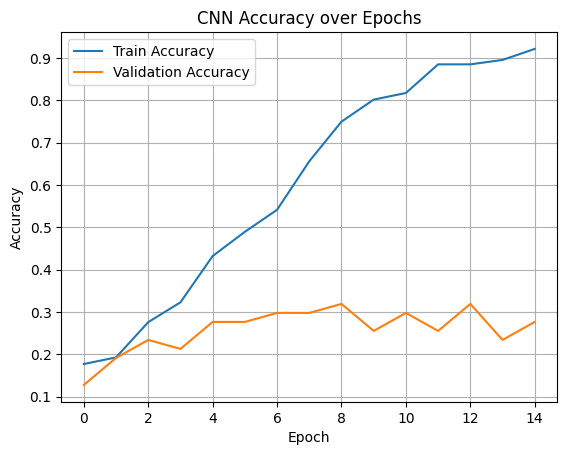

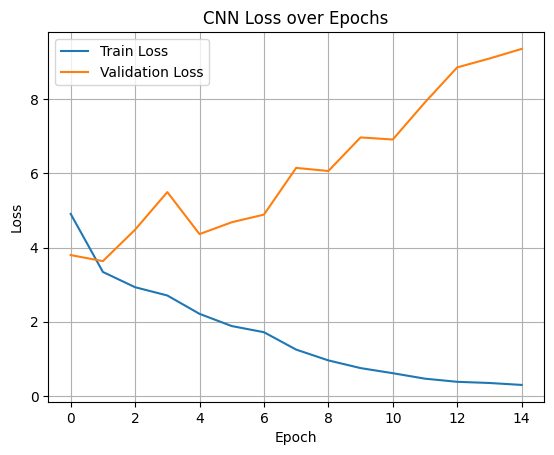

In [23]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Without data augmentation

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# Save the trained model
model.save("models/cnn_speaker_classifier.h5")

# Save training history as a JSON file
import json

with open("models/cnn_training_history.json", "w") as f:
    json.dump(history.history, f)

print("Model and training history saved!")


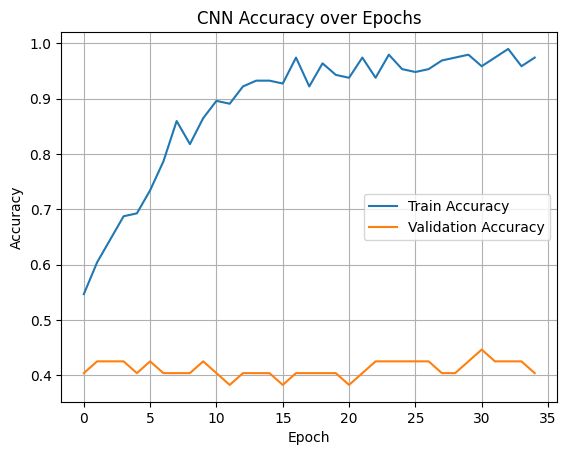

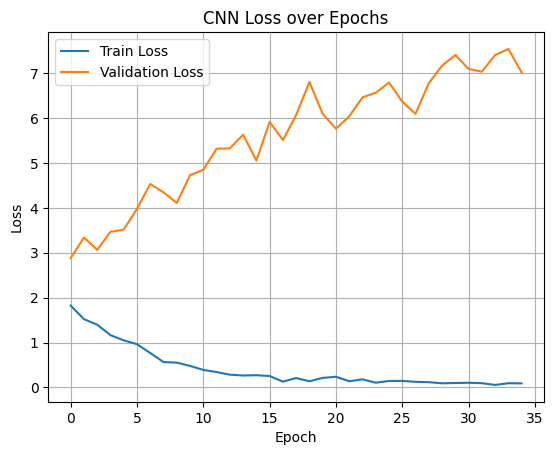

In [16]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The model start memorizing with more training

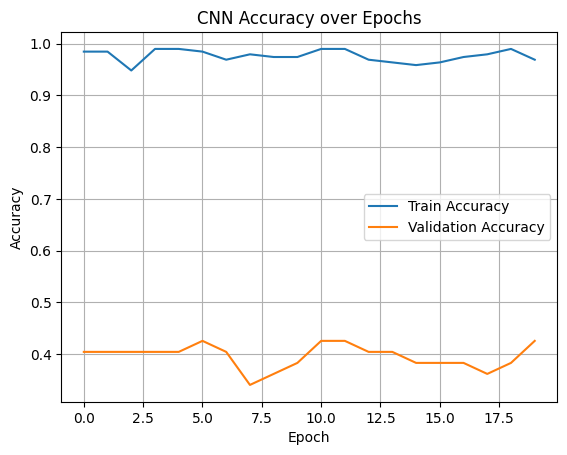

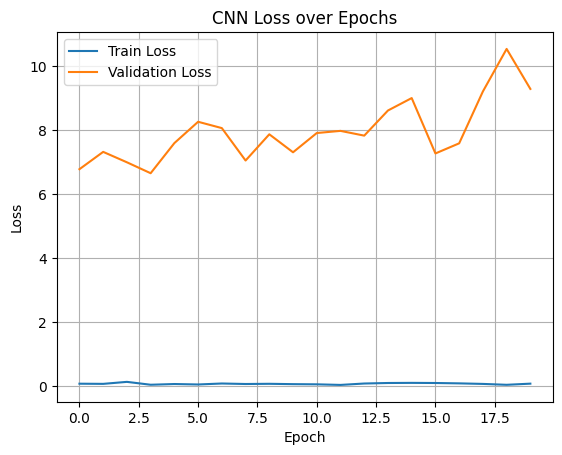

In [18]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

With EarlyStopping

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step - accuracy: 0.2145 - loss: 4.4816 - val_accuracy: 0.2553 - val_loss: 3.6074
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - accuracy: 0.2218 - loss: 3.3535 - val_accuracy: 0.2553 - val_loss: 3.6343
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.2792 - loss: 2.9265 - val_accuracy: 0.3191 - val_loss: 3.8086
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - accuracy: 0.4139 - loss: 2.5126 - val_accuracy: 0.2340 - val_loss: 4.1139
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.5367 - loss: 1.8109 - val_accuracy: 0.2766 - val_loss: 4.5416
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.5623 - loss: 1.7439 - val_accuracy: 0.3191 - val_loss: 4.8976
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 0.6094 - loss: 1.3944 - val_accuracy: 0.1702 - val_loss: 5.7286
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.6688 - loss: 1.2032 - val_accuracy: 0.3191 - val_loss:

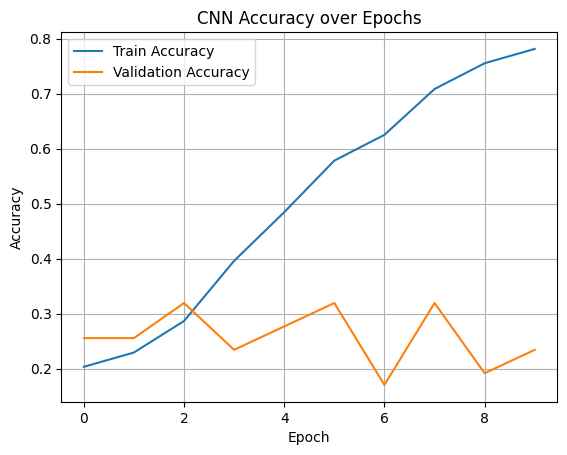

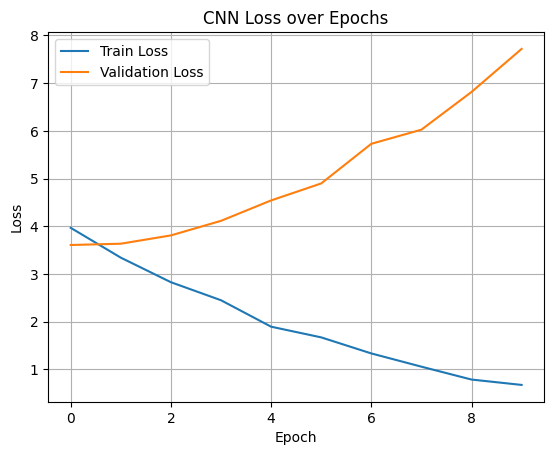

In [29]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20 
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.9220 - loss: 0.2881 - val_accuracy: 0.2766 - val_loss: 7.6286
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - accuracy: 0.9272 - loss: 0.2476 - val_accuracy: 0.2979 - val_loss: 8.0485
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.9368 - loss: 0.2419 - val_accuracy: 0.3191 - val_loss: 8.3379
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.9246 - loss: 0.2999 - val_accuracy: 0.3191 - val_loss: 8.3470
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - accuracy: 0.9586 - loss: 0.2001 - val_accuracy: 0.2766 - val_loss: 8.4198
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - accuracy: 0.8972 - loss: 0.2961 - val_accuracy: 0.2766 - val_loss: 8.4232
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 550ms/step - accuracy: 0.9391 - loss: 0.2149 - val_accuracy: 0.2553 - val_loss: 8.6879
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.9510 - loss: 0.1530 - val_accuracy: 0.2766 - val_loss:

# Evaluation For CNN

In [36]:
import numpy as np

# Get true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


2025-05-28 20:30:37.289138: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


CNN Validation Accuracy: 0.2979


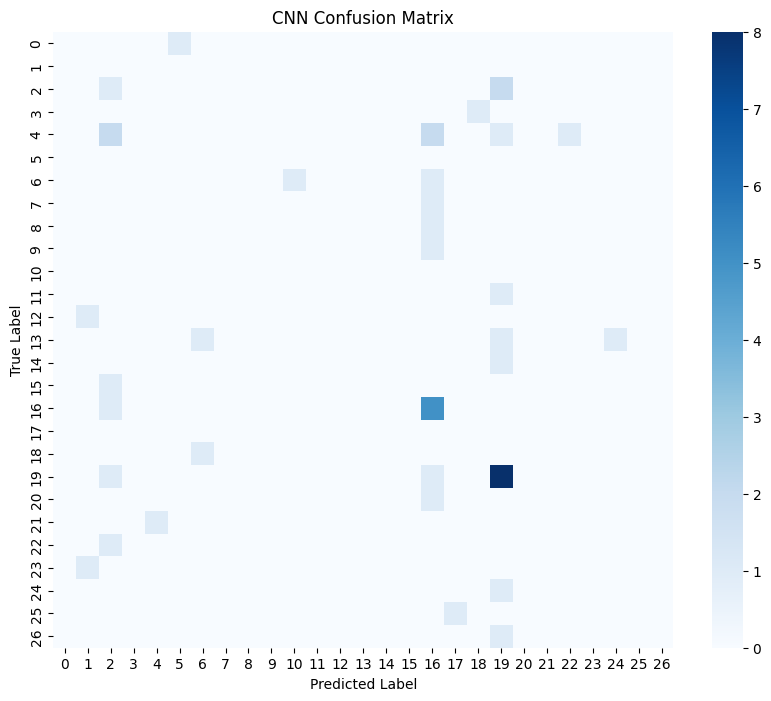

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"CNN Validation Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
